## Examples used in the slides for the SCALA@SC paper presentation
- Fitting data for execution logs or for synthetic logs
- Generating the sequence of requests
- Computing the cost of a sequence

Input data is represented by:
 * Log data for neuroscience applications (log_example.in)
     * Array of past execution times
 * Synthetic data

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import random

import WorkloadCDF
import OptimalSequence

In [2]:
plot = True

# Log data

If cost is needed use:
`cost_model = WorkloadFit.LogDataCost(data)`

This example computes the sequence of requests
- using the discrete data
- using both interpolation models (polynomial and distribution) to go through a continuous fit
- using distribution interpolation for the checkpoint sequence model

In [3]:
dataset = "./log_example.in"
data = np.loadtxt(dataset, delimiter=' ')
print("Total entries in the historic data: %d" %(len(data)))

Total entries in the historic data: 732


# Compute the discrete CDF

Plot it and show best fit by connecting adiacent points with a line

In [4]:
# Optimal CDF by using the descrete full data

wf = WorkloadCDF.WorkloadCDF(data)
optimal_data, optimal_cdf = wf.compute_discrete_cdf()

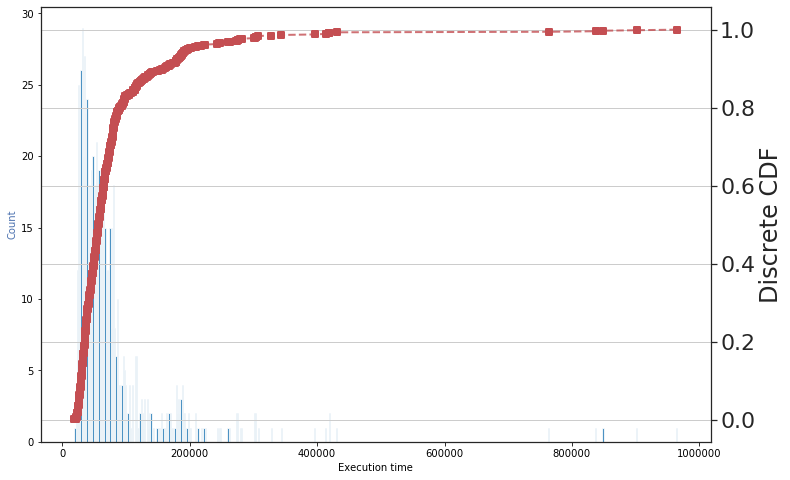

In [5]:
# plot the data and the descrete CDF (consecutive points joined by a line)

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8)

ax2.plot(optimal_data, optimal_cdf, 'r--', lw=2, alpha=0.8)
ax2.scatter(optimal_data, optimal_cdf, marker="s", color="r", lw=2, alpha=1)

plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="b")
if plot:
    plt.savefig("figures/optimal_discrete.png")
plt.show()

# Interpolate the CDF with a polynomial fit

- Maximum order of 9

In [6]:
# compute the interpolation of the CDF points

wf.set_interpolation_model([WorkloadCDF.PolyInterpolation(max_order=10)])
best_fit_poly = wf.compute_best_cdf_fit()
if best_fit_poly != -1:
     best_fit_poly = wf.get_best_fit()
print(best_fit_poly)

(9, array([-8.30715632e-51,  3.52663598e-44, -6.14070274e-38,  5.61536614e-32,
       -2.84852889e-26,  7.58162451e-21, -7.42145055e-16, -8.29471215e-11,
        2.38769945e-05, -5.07894933e-01]), 0.14880992722326458)


In [7]:
all_data_discrete, all_data_cdf = wf.get_interpolation_cdf(data, best_fit_poly[1])

# Interpolate the CDF with a logarithmic fit

In [8]:
# compute the interpolation of the CDF points

fct = np.log
wf.set_interpolation_model([WorkloadCDF.FunctionInterpolation(fct, order=2)])
best_fit_log = wf.compute_best_cdf_fit()
if best_fit_log != -1:
     best_fit_log = wf.get_best_fit()
print(best_fit_log)

(2, array([ -0.14033393,   3.60967572, -22.17700485]), 0.9911411058272521)


In [9]:
all_log_discrete, all_log_cdf = wf.get_interpolation_cdf(data, best_fit_log[1])

# Interpolate the CDF with a distribution fit

- get best disribution base on the fit

In [10]:
# compute the interpolation of the CDF points
wf.set_interpolation_model([WorkloadCDF.DistInterpolation(data)])
best_fit = wf.compute_best_cdf_fit()
if best_fit != -1:
     best_fit = wf.get_best_fit()
print(best_fit)

(<scipy.stats._continuous_distns.dweibull_gen object at 0x7f7ef4599cc0>, (0.7769322319646739, 52788.999999999985, 34791.237937332946), 243.3195805500859)


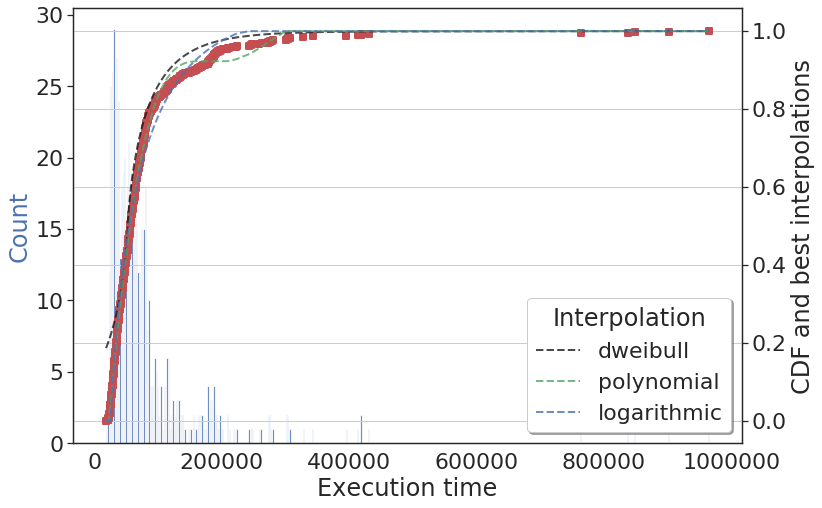

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8)

# distribution fit
arg = best_fit[1][:-2]
loc = best_fit[1][-2]
scale = best_fit[1][-1]
ax2.plot(optimal_data, best_fit[0].cdf(optimal_data, loc=loc, scale=scale, *arg),
         'k--', lw=2, alpha=0.8, label=best_fit[0].name)

# polynomial fit
ax2.plot(all_data_discrete, all_data_cdf, 'g--', lw=2, alpha=0.8, label="polynomial")
#ax2.plot(optimal_data, np.polyval(best_fit_poly[1], optimal_data), 'g--', lw=2, alpha=0.8, label="polynomial")

# logarithmic fit
ax2.plot(all_log_discrete, all_log_cdf, 'b--', lw=2, alpha=0.8, label="logarithmic")
#ax2.plot(optimal_data, np.polyval(best_fit_log[1], fct(optimal_data)), 'b--', lw=2, alpha=0.8, label="logarithmic")

# plot data
ax2.scatter(optimal_data, optimal_cdf, marker="s", color="r", lw=2, alpha=1)

plt.grid(True)
ax2.legend(shadow=True, title="Interpolation")
ax.set_xlabel('Execution time')
ax2.set_ylabel('CDF and best interpolations')
ax.set_ylabel('Count', color="b")
if plot:
    plt.savefig("figures/optimal_interpolation.png")
plt.show()

# Use only the first x entris in data for interpolation

In [12]:
# define x
training_size = 20

In [38]:
training_data = random.sample(list(data), training_size)
wf = WorkloadCDF.WorkloadCDF(training_data)
discret_data, cdf = wf.compute_discrete_cdf()

In [39]:
# create values that keep the cdf for the previous training point for all future points that are not part of the training set
#data.sort()
#all_data_cdf = []
#all_data_discrete = []
#last = 0
#for d in data:
#    if d in all_data_discrete:
#        continue
#    idx = [i for i in range(len(discret_data)) if discret_data[i] == d]
#    if len(idx) == 1:
#        last = cdf[idx[0]]
#    all_data_discrete.append(d)
#    all_data_cdf.append(last)

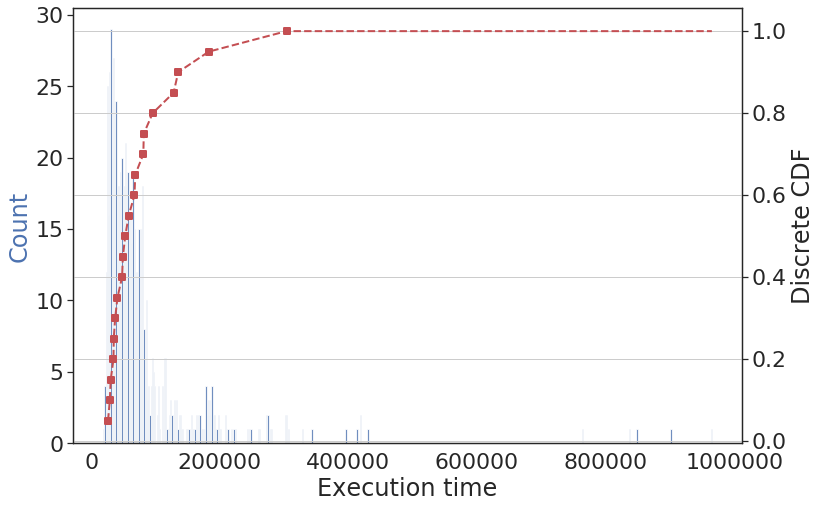

In [40]:
# plot the data and the descrete CDF (consecutive points joined by a line)

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8)

#ax2.plot(all_data_discrete, all_data_cdf, 'k--', lw=2, alpha=0.8)

ax2.plot(discret_data + [max(data)], cdf + [1], 'r--', lw=2, alpha=1)

ax2.scatter(discret_data, cdf, marker="s", color="r", lw=2, alpha=1)

plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="b")
if plot:
    plt.savefig("figures/training%d_discrete.png" %(training_size))
plt.show()

# Polynomial degree
- Compare polynomial fits for degrees of 10, 6 and 3
- For small training sets (20) the error is big for all 3
- For large training the fit is better for larger degrees

In [41]:
wf.set_interpolation_model([WorkloadCDF.PolyInterpolation(max_order=10)])
best_fit_poly8 = wf.compute_best_cdf_fit()
if best_fit_poly8 != -1:
     best_fit_poly8 = wf.get_best_fit()
print(best_fit_poly8)

(9, array([ 6.30032997e-46, -1.96204643e-40, -1.29839463e-34,  8.12264547e-29,
       -1.81498803e-23,  2.08633806e-18, -1.31226926e-13,  4.21694297e-09,
       -3.92962616e-05, -2.48464308e-01]), 0.005094186183883494)


In [42]:
all_data_discrete8, all_data_cdf8 = wf.get_interpolation_cdf(data, best_fit_poly8[1])

In [43]:
wf.set_interpolation_model([WorkloadCDF.PolyInterpolation(max_order=6)])
best_fit_poly = wf.compute_best_cdf_fit()
if best_fit_poly != -1:
     best_fit_poly = wf.get_best_fit()
print(best_fit_poly)

(5, array([ 7.52365778e-27, -6.82998962e-21,  2.42730956e-15, -4.32881347e-10,
        4.06918881e-05, -7.59957587e-01]), 0.006540921241468465)


In [44]:
all_data_discrete, all_data_cdf = wf.get_interpolation_cdf(data, best_fit_poly[1])

In [45]:
wf.set_interpolation_model([WorkloadCDF.PolyInterpolation(max_order=3)])
best_fit_poly3 = wf.compute_best_cdf_fit()
if best_fit_poly3 != -1:
     best_fit_poly3 = wf.get_best_fit()
print(best_fit_poly3)

(2, array([-2.60662539e-11,  1.13755033e-05, -1.03693484e-01]), 0.115424604527222)


In [46]:
all_data_discrete3, all_data_cdf3 = wf.get_interpolation_cdf(data, best_fit_poly3[1])

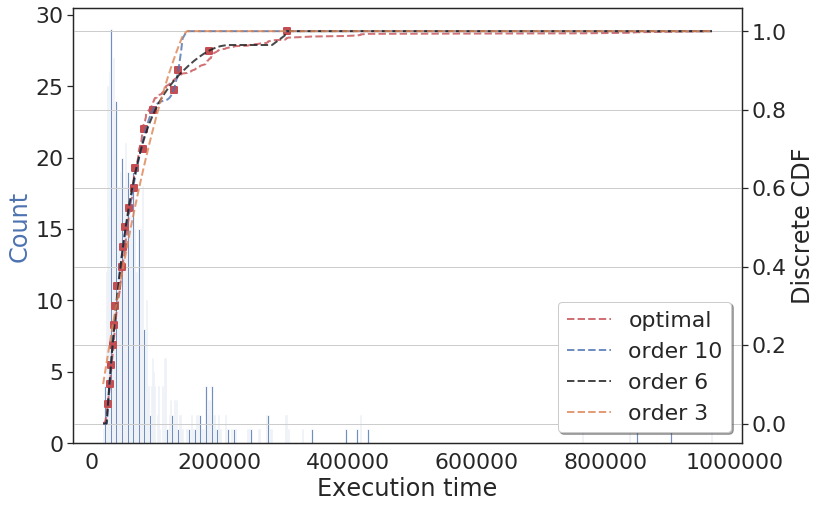

In [47]:
# plot the data and the descrete CDF (consecutive points joined by a line)

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8)

# Optimal fit
ax2.plot(optimal_data, optimal_cdf, 'r--', lw=2, alpha=0.8, label="optimal")

# Polynomial fit, rank 10
ax2.plot(all_data_discrete8, all_data_cdf8, '--', lw=2, alpha=0.8, label="order 10")
# Polynomial fit, rank 6
ax2.plot(all_data_discrete, all_data_cdf, 'k--', lw=2, alpha=0.8, label="order 6")
# Polynomial fit, rank 3
ax2.plot(all_data_discrete3, all_data_cdf3, '--', lw=2, alpha=0.8, label="order 3")


ax2.scatter(discret_data, cdf, marker="s", color="r", lw=2, alpha=1)

ax2.legend(shadow=True)
plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="b")
if plot:
    plt.savefig("figures/training%d_polynomial.png" %(training_size))
plt.show()

# Plot best polynomial and distribution fits compared to the optimal

In [48]:
wf.set_interpolation_model([WorkloadCDF.DistInterpolation(training_data)])
best_fit = wf.compute_best_cdf_fit()
if best_fit != -1:
     best_fit = wf.get_best_fit()
print(best_fit)

(<scipy.stats._continuous_distns.dweibull_gen object at 0x7f7ef4599cc0>, (0.7154825093044508, 48230.000000000015, 47479.19414115724), 7.056759040565251)


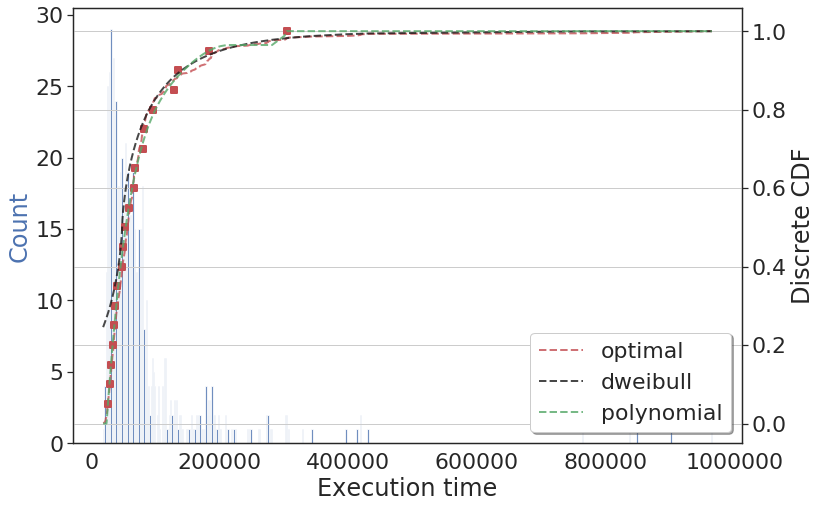

In [49]:
# plot the data and the descrete CDF (consecutive points joined by a line)

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8)

# Optimal fit
ax2.plot(optimal_data, optimal_cdf, 'r--', lw=2, alpha=0.8, label="optimal")

# Distribution fit
arg = best_fit[1][:-2]
loc = best_fit[1][-2]
scale = best_fit[1][-1]
ax2.plot(all_data_discrete, best_fit[0].cdf(all_data_discrete, loc=loc, scale=scale, *arg),
         'k--', lw=2, alpha=0.8, label=best_fit[0].name)

# Polynomial fit
ax2.plot(all_data_discrete, all_data_cdf, 'g--', lw=2, alpha=0.8, label="polynomial")

ax2.scatter(discret_data, cdf, marker="s", color="r", lw=2, alpha=1)

ax2.legend(shadow=True)
plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="b")
if plot:
    plt.savefig("figures/training%d_interpolation.png" %(training_size))
plt.show()